In [1]:
import pandas as pd
import os
import numpy as np

import tensorflow as tf

from transformers import AutoTokenizer, TFBertModel
from transformers import AutoImageProcessor, TFViTModel


from keras.utils import Sequence
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Dropout, Concatenate
from keras.callbacks import ModelCheckpoint
from keras.models import load_model, Model
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


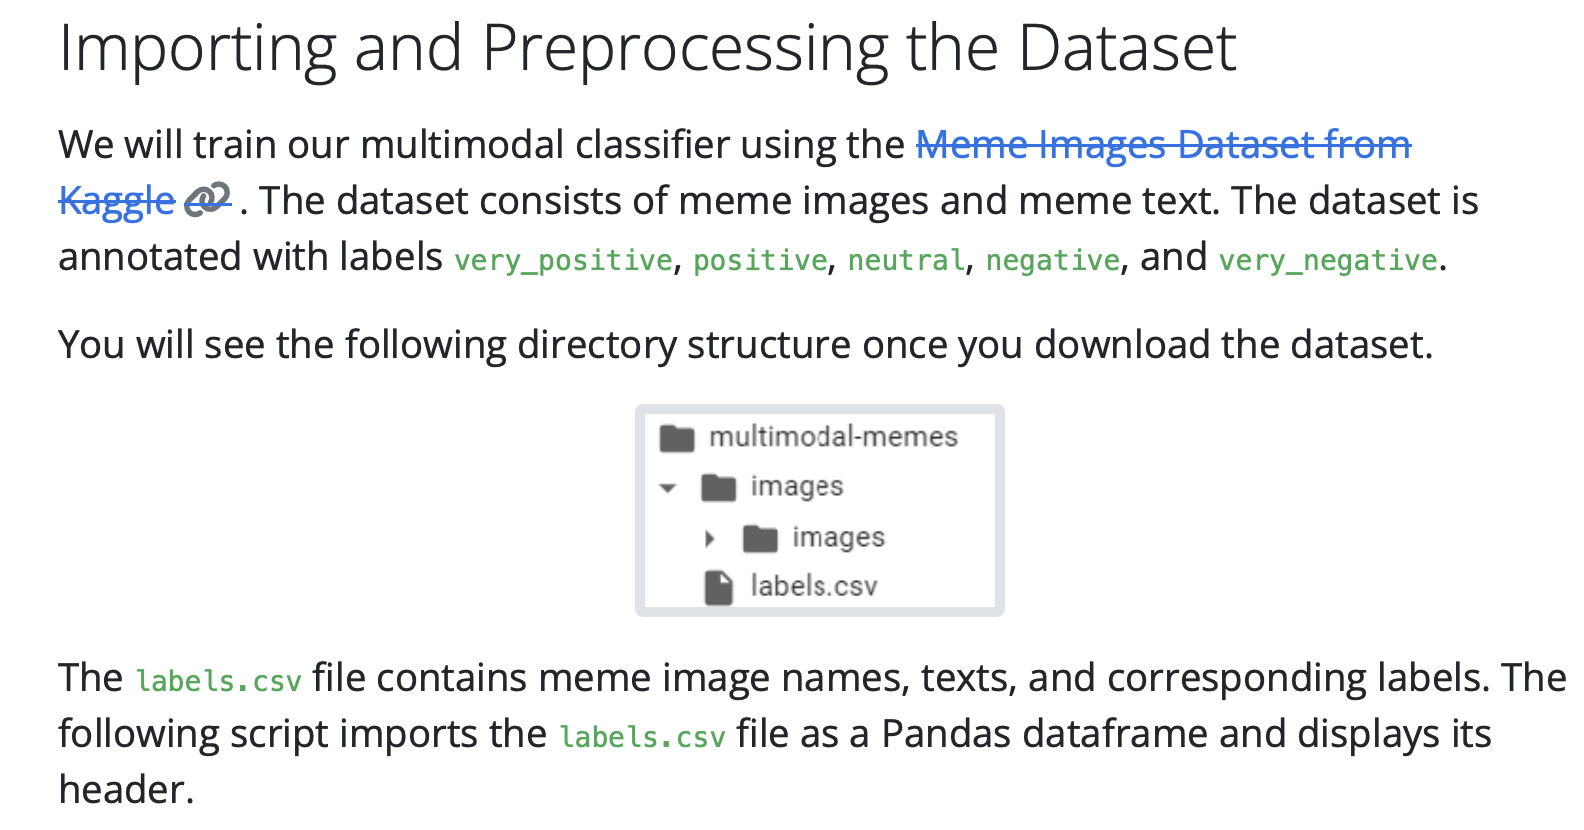

In [ ]:
labels_df = pd.read_csv("/content/multimodal-memes/labels.csv")
labels_df.head()


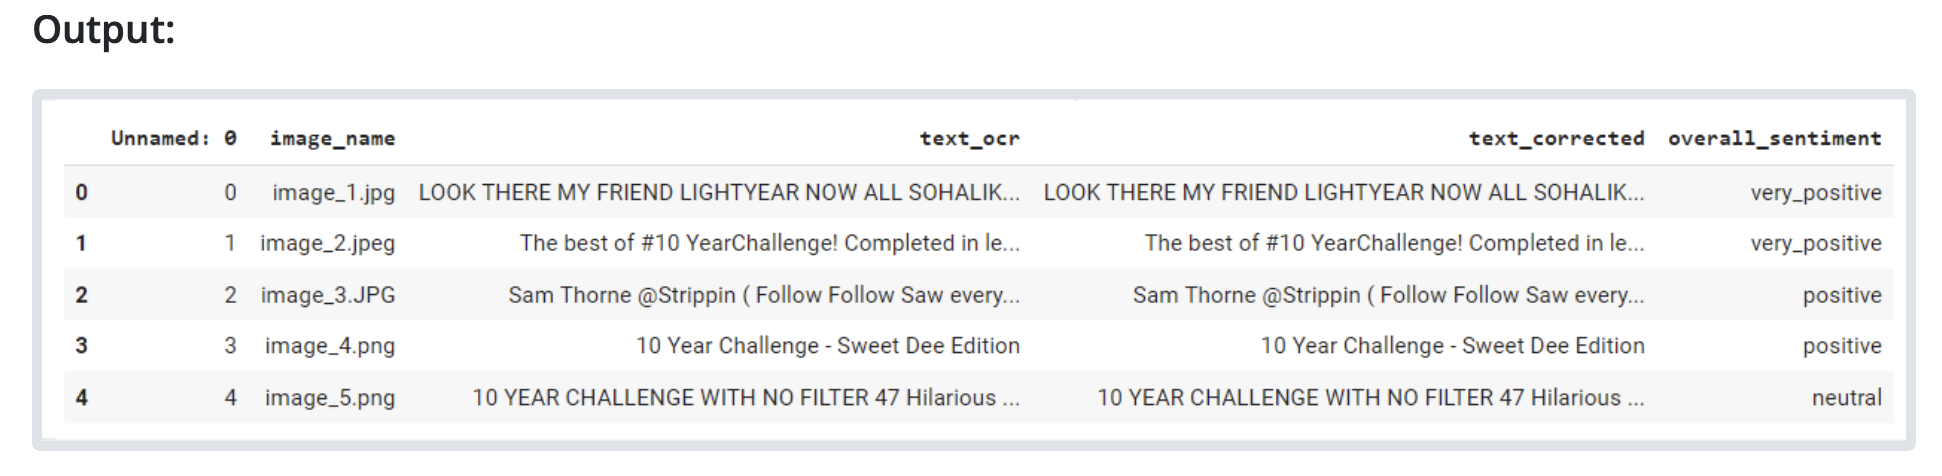

In [ ]:
image_folder_path = '/content/multimodal-memes/images/images'
labels_df['image_path'] = labels_df['image_name'].apply(lambda x: os.path.join(image_folder_path, x))
labels_df = labels_df[labels_df['text_corrected'].notna() & (labels_df['text_corrected'] != '')]
labels_df = labels_df.filter(["text_corrected", "image_path", "overall_sentiment"])


In [ ]:
labels_df['overall_sentiment'] = labels_df['overall_sentiment'].replace({'very_positive': 'positive', 'very_negative': 'negative'})
labels_df = labels_df.sample(frac=1).reset_index(drop=True)


In [ ]:

X = labels_df.drop('overall_sentiment', axis=1)
y = labels_df["overall_sentiment"]

# convert labels to one-hot encoded vectors
y = pd.get_dummies(y)


In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=60)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=60)

In [ ]:

## importing text model and tokenizer

bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

for layer in bert_model.layers[:-4]:
    layer.trainable = False

## importing image model and tokenizer

image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
vit_model = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

for layer in vit_model.layers[:-4]:
    layer.trainable = False


In [ ]:

class MultiModalDataGenerator(Sequence):

    def __init__(self, df, labels, tokenizer, image_processor, batch_size=32, max_length=128):
        self.df = df
        self.labels_df = labels
        self.tokenizer = tokenizer
        self.image_processor = image_processor
        self.batch_size = batch_size
        self.max_length = max_length

    def __len__(self):
        # Number of batches per epoch
        return int(np.ceil(len(self.df) / float(self.batch_size)))

    def __getitem__(self, idx):
        # Batch indices
        batch_indices = self.df.index[idx * self.batch_size:(idx + 1) * self.batch_size]

        # Initialize lists to store data
        batch_texts = []
        batch_images = []
        batch_labels = []

        # Loop over each index in the batch
        for i in batch_indices:
            # Append text
            batch_texts.append(self.df.at[i, 'text_corrected'])  # Replace 'text_column' with the name of your text column
            # Append Image paths

            batch_images.append(Image.open(self.df.at[i, 'image_path']).convert("RGB"))

            # Fetch labels
            label_values = self.labels_df.loc[i].values
            batch_labels.append(label_values)

        # Tokenize text data in the batch
        tokenized_data = self.tokenizer(batch_texts, padding='max_length', truncation=True, max_length=self.max_length, return_tensors="tf")

        # Process images

        processed_images = [self.image_processor(images=image, return_tensors="tf") for image in batch_images]
        image_tensors = tf.concat([img['pixel_values'] for img in processed_images], axis=0)


        # Convert labels to numpy array
        batch_labels = np.array(batch_labels, dtype='float32')

        final_features = {'input_ids': tokenized_data['input_ids'],
                          'attention_mask': tokenized_data['attention_mask'],
                          'image_input': image_tensors}
        return final_features, batch_labels



In [ ]:

max_text_length = 128
batch_size = 8

train_generator = MultiModalDataGenerator(X_train,
                                y_train,
                                bert_tokenizer,
                                image_processor,
                                batch_size,
                                max_text_length)

test_generator = MultiModalDataGenerator(X_test,
                                y_test,
                                bert_tokenizer,
                                image_processor,
                                batch_size,
                                max_text_length)

val_generator = MultiModalDataGenerator(X_val,
                              y_val,
                              bert_tokenizer,
                              image_processor,
                              batch_size,
                              max_text_length)



In [ ]:

# Define input layers for text
input_ids = Input(shape=(None,), dtype=tf.int32, name="input_ids")
attention_mask = Input(shape=(None,), dtype=tf.int32, name="attention_mask")

# Define input layer for images
image_input = Input(shape=(3, 224, 224), dtype=tf.float32, name="image_input")

# Get the output of BERT model
bert_outputs = bert_model(input_ids, attention_mask=attention_mask)
pooled_output = bert_outputs.pooler_output

# Get the output of ViT model
vit_outputs = vit_model(image_input)
vit_pooled_output = vit_outputs.pooler_output

# Concatenate the outputs from BERT and ViT
concatenated_outputs = Concatenate()([pooled_output, vit_pooled_output])


# Add additional layers for fine-tuning
x = Dense(512, activation='relu')(concatenated_outputs)
x = Dropout(0.1)(x)
final_output = tf.keras.layers.Dense(3, activation='softmax')(x)

# Create the model
model = Model(inputs=[input_ids, attention_mask, image_input], outputs=final_output)

adam_optimizer = Adam(learning_rate=2e-5)

# Compile the model
model.compile(optimizer = adam_optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])




In [ ]:

# Define the checkpoint callback
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=False
)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=[checkpoint],
    verbose=1
)



In [ ]:

# Load the model, including the custom TFBertModel and TFViTModel layers
custom_objects = {"TFBertModel": TFBertModel, "TFViTModel": TFViTModel}
best_model = load_model('best_model.h5', custom_objects=custom_objects)


predictions = best_model.predict(test_generator)

# convert predicitons to binary values
predictions = (predictions == predictions.max(axis=1)[:, None]).astype(int)

# printing results
print(classification_report(y_test, predictions))
print(f"Accuracy score: {accuracy_score(y_test, predictions)}")


In [ ]:
#ChatGpt Ai

In [ ]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Conv2D, MaxPooling2D, Flatten, Dropout, Concatenate, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from keras.utils import Sequence
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Load dataset and prepare image paths
labels_df = pd.read_csv("/content/book_data.csv")
image_folder_path = '/content/book_covers'
labels_df['image_path'] = labels_df['image_name'].apply(lambda x: os.path.join(image_folder_path, x))

# Preprocess text data (replace 'text_corrected' with your actual text column)
labels_df['text_combined'] = labels_df['name'] + ' ' + labels_df['author']
X = labels_df[['text_combined', 'image_path']]
y = pd.get_dummies(labels_df['genre'])

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Tokenizer for text
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train['text_combined'])

# Define ImageDataGenerator for images
train_datagen = ImageDataGenerator(rescale=1./255., rotation_range=10, width_shift_range=0.1,
                                   height_shift_range=0.1, zoom_range=0.2, horizontal_flip=True)

class MultiModalDataGenerator(Sequence):
    def __init__(self, df, labels, tokenizer, batch_size=32, image_size=(224, 224), max_length=100):
        self.df = df
        self.labels = labels
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.image_size = image_size
        self.max_length = max_length
        self.datagen = train_datagen  # ImageDataGenerator for image augmentation

    def __len__(self):
        return int(np.ceil(len(self.df) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_indices = self.df.index[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        batch_texts = []
        batch_images = []
        batch_labels = []

        for i in batch_indices:
            # Preprocess text
            batch_texts.append(self.df.at[i, 'text_combined'])
            
            # Preprocess images
            img = Image.open(self.df.at[i, 'image_path']).convert("RGB")
            img = img.resize(self.image_size)
            img = np.array(img) / 255.0
            batch_images.append(img)

            # Labels
            label_values = self.labels.loc[i].values
            batch_labels.append(label_values)

        # Tokenize and pad text sequences
        text_sequences = self.tokenizer.texts_to_sequences(batch_texts)
        text_padded = pad_sequences(text_sequences, maxlen=self.max_length)

        return [np.array(batch_images), np.array(text_padded)], np.array(batch_labels)

# Create the CNN model for images
def create_cnn_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    return Model(inputs, x)

# Create the LSTM model for text
def create_lstm_model(input_length, vocab_size):
    inputs = Input(shape=(input_length,))
    x = Embedding(vocab_size, 128)(inputs)
    x = LSTM(128)(x)
    return Model(inputs, x)

# Combining CNN and LSTM in a multimodal model
def create_multimodal_model(cnn_model, lstm_model, num_classes):
    combined = Concatenate()([cnn_model.output, lstm_model.output])
    x = Dense(128, activation='relu')(combined)
    x = Dropout(0.2)(x)
    output = Dense(num_classes, activation='softmax')(x)
    return Model([cnn_model.input, lstm_model.input], output)

# Hyperparameters
max_text_length = 100
vocab_size = len(tokenizer.word_index) + 1
batch_size = 32
image_shape = (224, 224, 3)
num_classes = y_train.shape[1]

# Create the models
cnn_model = create_cnn_model(image_shape)
lstm_model = create_lstm_model(max_text_length, vocab_size)
multimodal_model = create_multimodal_model(cnn_model, lstm_model, num_classes)

# Compile the multimodal model
adam_optimizer = Adam(learning_rate=1e-4)
multimodal_model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Prepare the data generators
train_generator = MultiModalDataGenerator(X_train, y_train, tokenizer, batch_size=batch_size, max_length=max_text_length)
val_generator = MultiModalDataGenerator(X_val, y_val, tokenizer, batch_size=batch_size, max_length=max_text_length)

# Train the model
history = multimodal_model.fit(train_generator, validation_data=val_generator, epochs=10, verbose=1)

# Evaluate the model
test_generator = MultiModalDataGenerator(X_test, y_test, tokenizer, batch_size=batch_size, max_length=max_text_length)
test_predictions = multimodal_model.predict(test_generator)

# Convert predictions to labels
predicted_classes = np.argmax(test_predictions, axis=1)
true_classes = np.argmax(y_test.values, axis=1)

# Print classification report
print(classification_report(true_classes, predicted_classes))


In [ ]:
class MultiModalDataGenerator(Sequence):
    def __init__(self, df, labels, tokenizer, batch_size=32, image_size=(224, 224), max_length=100, datagen=None):
        self.df = df
        self.labels = labels
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.image_size = image_size
        self.max_length = max_length
        self.datagen = datagen if datagen else ImageDataGenerator(rescale=1./255.)  # Default ImageDataGenerator

    def __len__(self):
        return int(np.ceil(len(self.df) / float(self.batch_size)))

    def __getitem__(self, idx):
        # Batch indices
        batch_indices = self.df.index[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        batch_texts = []
        batch_images = []
        batch_labels = []

        for i in batch_indices:
            # Preprocess text
            batch_texts.append(self.df.at[i, 'text_combined'])
            
            # Preprocess images
            img = Image.open(self.df.at[i, 'image_path']).convert("RGB")
            img = img.resize(self.image_size)
            img = np.array(img)  # Convert to numpy array (no normalization here yet)
            batch_images.append(img)

            # Labels
            label_values = self.labels.loc[i].values
            batch_labels.append(label_values)

        # Tokenize and pad text sequences
        text_sequences = self.tokenizer.texts_to_sequences(batch_texts)
        text_padded = pad_sequences(text_sequences, maxlen=self.max_length)

        # Apply ImageDataGenerator transformations
        batch_images = np.array(batch_images)
        batch_images_augmented = np.zeros_like(batch_images)
        for i in range(len(batch_images)):
            batch_images_augmented[i] = self.datagen.random_transform(batch_images[i])  # Apply augmentations

        return [batch_images_augmented, np.array(text_padded)], np.array(batch_labels)


In [ ]:
# Define custom ImageDataGenerator for augmenting images
train_datagen = ImageDataGenerator(rescale=1./255., rotation_range=10, width_shift_range=0.1,
                                   height_shift_range=0.1, zoom_range=0.2, horizontal_flip=True)

# Create data generators with the augmented ImageDataGenerator for training
train_generator = MultiModalDataGenerator(X_train, y_train, tokenizer, batch_size=batch_size, max_length=max_text_length, datagen=train_datagen)
val_generator = MultiModalDataGenerator(X_val, y_val, tokenizer, batch_size=batch_size, max_length=max_text_length)

# Train the model using the generators
history = multimodal_model.fit(train_generator, validation_data=val_generator, epochs=10, verbose=1)


In [ ]:
import matplotlib.pyplot as plt

# Function to check if the batch is correct
def inspect_batch(data_generator, batch_num=0):
    # Get the batch
    (image_batch, text_batch), label_batch = data_generator[batch_num]
    
    for i in range(len(image_batch)):
        # Display the image
        plt.imshow(image_batch[i])
        plt.axis('off')
        plt.show()
        
        # Print the corresponding text
        text_sequence = text_batch[i]
        decoded_text = ' '.join([tokenizer.index_word.get(idx, '') for idx in text_sequence if idx != 0])
        print(f"Text: {decoded_text}")
        
        # Print the label
        print(f"Label (one-hot encoded): {label_batch[i]}")
        print("-" * 50)

# Inspect the first batch in the training generator
inspect_batch(train_generator, batch_num=0)


In [ ]:
# Calude Ai

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Conv2D, MaxPooling2D, Flatten, Embedding, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from PIL import Image

class MultiModalDataGenerator(Sequence):
    def __init__(self, df, labels, tokenizer, img_size=(224, 224), batch_size=32, max_length=128):
        self.df = df
        self.labels_df = labels
        self.tokenizer = tokenizer
        self.img_size = img_size
        self.batch_size = batch_size
        self.max_length = max_length
        self.image_datagen = ImageDataGenerator(rescale=1./255, rotation_range=2, 
                                                width_shift_range=0.01, height_shift_range=0.02, 
                                                shear_range=0.0, zoom_range=0.2, horizontal_flip=True)

    def __len__(self):
        return int(np.ceil(len(self.df) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_indices = self.df.index[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_texts = []
        batch_images = []
        batch_labels = []

        for i in batch_indices:
            batch_texts.append(self.df.at[i, 'Final'])
            img = Image.open(self.df.at[i, 'Image']).convert("RGB").resize(self.img_size)
            img_array = np.array(img)
            img_array = self.image_datagen.random_transform(img_array)
            batch_images.append(img_array)
            batch_labels.append(self.labels_df.loc[i].values)

        # Tokenize and pad text data
        sequences = self.tokenizer.texts_to_sequences(batch_texts)
        padded_sequences = pad_sequences(sequences, maxlen=self.max_length, padding='post', truncating='post')

        # Convert images to numpy array
        batch_images = np.array(batch_images)

        # Convert labels to numpy array
        batch_labels = np.array(batch_labels, dtype='float32')

        return {'text_input': padded_sequences, 'image_input': batch_images}, batch_labels

def create_multimodal_model(vocab_size, max_length, img_shape, num_classes):
    # Text input
    text_input = Input(shape=(max_length,), name='text_input')
    embedding = Embedding(input_dim=vocab_size, output_dim=100, input_length=max_length)(text_input)
    lstm = LSTM(128)(embedding)

    # Image input
    image_input = Input(shape=img_shape, name='image_input')
    conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(image_input)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    flatten = Flatten()(pool2)

    # Combine text and image features
    concatenated = Concatenate()([lstm, flatten])
    dense1 = Dense(128, activation='relu')(concatenated)
    dropout = Dropout(0.5)(dense1)
    output = Dense(num_classes, activation='softmax')(dropout)

    model = Model(inputs=[text_input, image_input], outputs=output)
    return model


vocab_size = 10000
max_length = 128
img_shape = (224, 224, 3)
num_classes = 4  

model = create_multimodal_model(vocab_size, max_length, img_shape, num_classes)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Create data generators
train_generator = MultiModalDataGenerator(X_train, y_train, tokenizer, batch_size=32)
val_generator = MultiModalDataGenerator(X_val, y_val, tokenizer, batch_size=32)
test_generator = MultiModalDataGenerator(X_test, y_test, tokenizer, batch_size=32)

# Train the model
history = model.fit(train_generator, validation_data=val_generator, epochs=10, verbose=1)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy}")

NameError: name 'X_train' is not defined

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train['text_corrected'])

In [ ]:
train_generator = MultiModalDataGenerator(X_train, y_train, tokenizer, batch_size=32)
val_generator = MultiModalDataGenerator(X_val, y_val, tokenizer, batch_size=32)
test_generator = MultiModalDataGenerator(X_test, y_test, tokenizer, batch_size=32)

In [ ]:
model = create_multimodal_model(vocab_size, max_length, img_shape, num_classes)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator, validation_data=val_generator, epochs=10, verbose=1)

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy}")

In [ ]:
class MultiModalDataGenerator(Sequence):
    # ... (previous code remains the same)

    def get_example(self, idx):
        """Return a single example for verification purposes."""
        text = self.df.at[idx, 'text_corrected']
        img_path = self.df.at[idx, 'image_path']
        label = self.labels_df.loc[idx].values

        # Preprocess text
        sequence = self.tokenizer.texts_to_sequences([text])
        padded_sequence = pad_sequences(sequence, maxlen=self.max_length, padding='post', truncating='post')

        # Preprocess image
        img = Image.open(img_path).convert("RGB").resize(self.img_size)
        img_array = np.array(img)
        img_array = self.image_datagen.random_transform(img_array)
        img_array = img_array / 255.0  # Rescale

        return {
            'original_text': text,
            'processed_text': padded_sequence,
            'image_path': img_path,
            'processed_image': img_array,
            'label': label
        }

# Usage example:
generator = MultiModalDataGenerator(X_train, y_train, tokenizer, batch_size=32)
example = generator.get_example(0)
print("Original text:", example['original_text'])
print("Processed text shape:", example['processed_text'].shape)
print("Image path:", example['image_path'])
print("Processed image shape:", example['processed_image'].shape)
print("Label:", example['label'])

# Verify a batch
batch_x, batch_y = generator[0]
print("Batch text input shape:", batch_x['text_input'].shape)
print("Batch image input shape:", batch_x['image_input'].shape)
print("Batch label shape:", batch_y.shape)